In [1]:
import os

source_folder = ["banana", "bareland", "carrot", "corn", "dragonfruit", "garlic", "guava", "peanut", 
                 "pineapple", "pumpkin", "rice", "sugarcane", "tomato", "soybean"]
picture_number = {}

for item in source_folder:
    item_number = len(os.listdir(item))
    picture_number[item] = item_number

<AxesSubplot:>

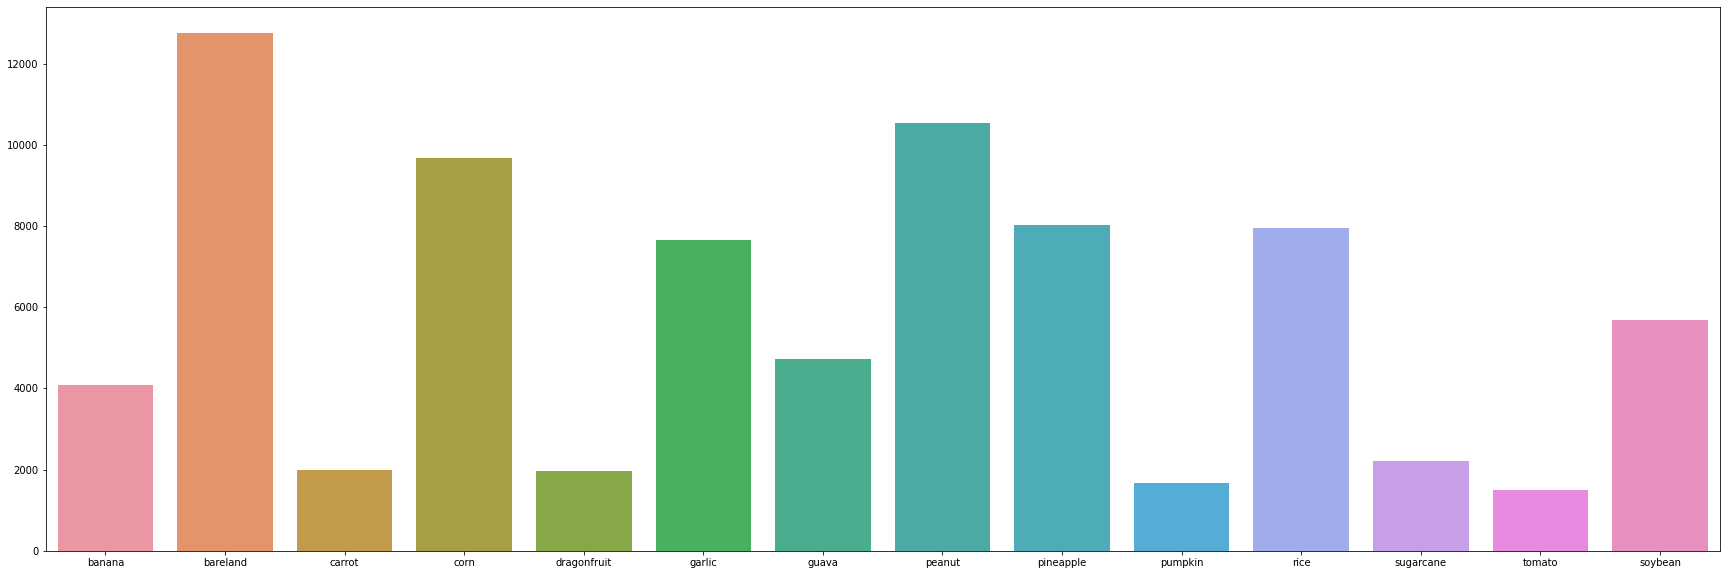

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

keys = list(picture_number.keys())
vals = [(picture_number[k]) for k in keys]
sns.barplot(x=keys, y=vals)

confused matrix

In [3]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dset

convnext_tiny = models.convnext_tiny(pretrained=False)
convnext_tiny.classifier[2] = nn.Linear(768,15)
convnext_tiny.load_state_dict(torch.load('new_convnext_all_calss_epoch_20_weight2.ckpt'))
convnext_tiny.eval()

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [4]:
class CropDataset(Dataset):
    """Crop dataset."""

    def __init__(self, root_dir, label_dict, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_dict = label_dict
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.root_dir))
    
    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        image_path = os.path.join(self.root_dir, img_name)
        image = Image.open(image_path).convert('RGB')
        
        label = self.label_dict[img_name.split("_")[0]]
        if self.transform:
            image = self.transform(image)
        return image, label, img_name

In [5]:
DevImagePath = "./test_all_2"

featuretransform = transforms.Compose([transforms.Resize(255), 
                                       transforms.CenterCrop(224),  
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

label_dict = {"banana":0, "bareland":1, "carrot":2, "corn":3, "dragonfruit":4, "garlic":5, "guava":6, "inundated":7, "peanut":8, 
                 "pineapple":9, "pumpkin":10, "rice":11, "sugarcane":12, "tomato":13, "soybean":14}


valDataset = CropDataset(DevImagePath, label_dict, featuretransform)
valLoader = torch.utils.data.DataLoader(
         valDataset,batch_size= 128, shuffle= False, num_workers= 1)

In [11]:
import os
from PIL import Image
import numpy as np

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = convnext_tiny.to(device)
y_pred = []   #保存預測label
y_true = []   #保存實際label
image_name_list = []

with torch.no_grad():
    correct, total = 0, 0
    for images, labels, image_name in valLoader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        false_index = np.where((predicted != labels).cpu().numpy())[0].tolist()
#         print(np.where((predicted != labels).cpu().numpy())[0].tolist() )
        #print(false_index)
        for index in false_index:
            #print(image_name[index])
            #print(predicted[index])
            #print(labels[index])
            #y_pred.extend(predicted.view(-1).detach().cpu().numpy())
            #y_true.extend(labels.view(-1).detach().cpu().numpy())
            y_pred.append(predicted.view(-1).detach().cpu().numpy()[index])
            y_true.append(labels.view(-1).detach().cpu().numpy()[index])
            image_name_list.append(image_name[index])
        #break
f = open("error_new_convnext_all_calss_epoch_20_weight2.txt","w")
for i in range(0, len(y_pred)):
    f.writelines("{0}, {1}, {2}\n".format(image_name_list[i], y_pred[i], y_true[i]))
#     print(image_name_list[i])
#     print(y_pred[i])
#     print(y_true[i])
f.close()

In [7]:
device

'cuda:0'

<AxesSubplot:>

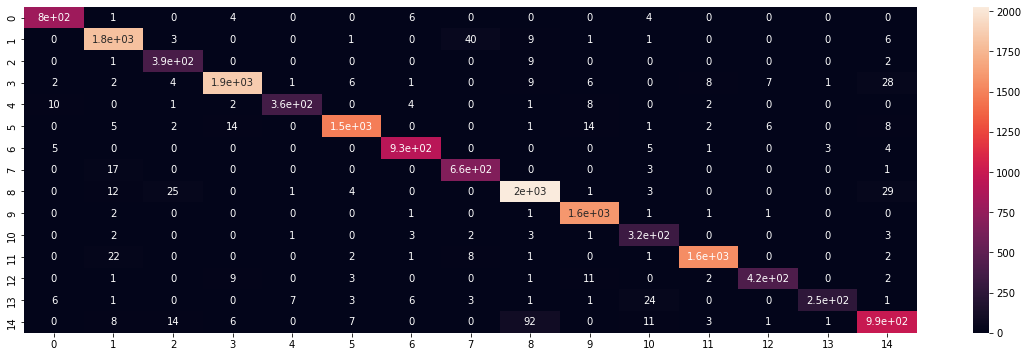

In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(20, 6))
result = confusion_matrix(y_true, y_pred)
sns.heatmap(result, annot=True)

In [13]:
result[14]

array([  0,  15,   4,  12,   0,  25,  10,   0, 160,   1,   6,   8,   2,
         0, 894])